<a href="https://colab.research.google.com/github/ttogle918/AI_practice/blob/main/%EB%AC%B8%EC%9E%A5%EA%B2%80%EC%83%89/workflow%EC%84%A4%EA%B3%84_onlyone_%EC%9E%84%EA%B3%84%EA%B0%92_0_7_0_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 준비

In [ ]:
!pip install pytorch-transformers transformers
!pip install sentence-transformers
!pip install -q konlpy tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 34.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 20.1 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-0.0.

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import f1_score
from scipy import stats
import time
import matplotlib.pyplot as plt
from datetime import datetime
import math
import random

from sentence_transformers import SentenceTransformer,  LoggingHandler, losses, models, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.readers import InputExample

from transformers import AutoTokenizer, AutoModel, TextClassificationPipeline
from transformers import pipeline

In [ ]:
# gpu 연산이 가능하면 'cuda:0', 아니면 'cpu' 출력
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device, torch.cuda.device_count()

(device(type='cuda', index=0), 1)

## 데이터셋 Load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/비상바로가기/최지현/<온리원>/생성된데이터/onlyone_question_temp.csv')
df.head()

In [ ]:
df.columns

Index(['질문키', '질문자키', '질문자명', '선생님아이디', '선생님이름', '질문제목', '질문내용', '과목명', '상품명',
       '강의명', '질문등록일', '답변키', '답변자키', '답변자명', '답변제목', '답변내용', '답변등록일', '질문',
       '답변', 'filter_criterion', '길이', '질문여부'],
      dtype='object')

In [ ]:
df['질문'] = df['강의명'] + df['질문제목'] + df['질문내용']

In [ ]:
df_question = pd.read_csv('/content/drive/MyDrive/비상바로가기/최지현/<온리원>/생성된데이터/only_questions.csv')
df_question['질문'] = df_question['강의명'] + df_question['질문제목'] + df_question['질문내용']

df_question.head(3)

In [ ]:
df_question = df_question.drop(columns=['답변키', '답변자키', '답변자명', '답변제목', '답변내용', '답변등록일'])
df_question.head()

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, sentence, labels=None):
        self.sentence = sentence
        self.labels = labels
    
    def __getitem__(self, index):
        if self.labels is not None:
            return self.sentence[index], self.labels[index]
        else:
            return self.sentence[index]

    def __len__(self):
        return len(self.sentence)

In [ ]:
base_dataset = CustomDataset(df['질문'].tolist(), df['답변내용'].tolist())

In [ ]:
len(df)

1533

# 유사한 문장 얻기

In [ ]:
from sklearn.metrics import f1_score
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.neighbors import NearestNeighbors
import requests
from bs4 import BeautifulSoup

class CustomClass() :
  def __init__(self, sentiment_model_path, eth_model_path, fword_path, similarity_model_path, base_questions) :
    self.pipe_sentiment = pipeline(model=sentiment_model_path) # 감성 분석
    self.pipe_eth = pipeline(model=eth_model_path) # 윤리적 문장인지 분류

    # 욕설 단어를 포함한 게시글인지 확인
    self.fword = []
    with open(fword_path, 'r') as f :
      for line in f.readlines() :
        self.fword.append(line.replace('\n', '').strip())
  
    self.embedder = SentenceTransformer(similarity_model_path)    # 유사도 측정한 모델

    # 기존 문장 임베딩
    self.corpus_embeddings = self.embedder.encode(base_questions['질문'].tolist())
    self.answers = base_questions['답변내용'].copy()
    
  def preprocessing(self, df) :
    df['질문'] = df['질문'].apply(lambda x : BeautifulSoup(x,"html5lib").get_text())
    # df['답변내용'] = df['답변내용'].apply(lambda x : BeautifulSoup(x,"html5lib").get_text())
    # df['질문'] = df['질문'].apply(lambda x : ''.join(dict.fromkeys(x) ) )
    return df

  def run(self, df, model_name, threshold=-1) :
    df = self.preprocessing(df)
    print(f'원래 dataset : {len(self.corpus_embeddings)}\n')

    # 부정 문장 제거
    df, df_negative = self.remove_negative(df)
    
    # 부정적인 질문 print
    print(f'부정적인 질문 list. 총 {len(df_negative)}개\n')
    for q in df_negative.질문 :
      print(q)
    
    # 욕설 문장 제거
    df, df_fword = self.remove_fword(df)
    print(f'욕설이 포함된 질문 list. 총 {len(df_fword)}개\n')
    for q in df_fword.질문 :
      print(q)

    # 비윤리적 문장 제거
    df, df_unethical = self.remove_uneth(df)
    print(f'비윤리적 문장인 질문 list. 총 {len(df_unethical)}개\n')
    for q in df_unethical.질문 :
      print(q)

    # 유사한 질문 문장 index 얻기
    print('similarity')
    if threshold >= 1 :   # 1이상이면 k개 선택하라는 의미
      top_k = min(threshold, len(self.corpus_embeddings))
      # top_results = get_Neighbors(queries, questions, top_k) :    # dist, idx
      top_results = self.get_similar_sentences(df, top_k)    # score, idx
    else :    # 1 미만이라면 ( 원래는 -1 ~ 1 까지의 값 가능 ) 유사도가 임계값 이상인 데이터만 사용하라는 의미
      top_results = self.get_similar_sentences_by_threshold(df, threshold)    # score, idx

    # 유사한 질문 문장과 그 답변 print
    return top_results, df

    return top_results
  def remove_fword(self, df) :
    df['have_fword'] = df['질문'].apply(lambda q : sum([q.count(fw) for fw in self.fword]) )
    df_fword = df[df['have_fword'] > 0].copy()
    df = df.drop(df[df['have_fword'] > 0].index)
    df = df.drop(columns=['have_fword'])
    return df, df_fword

  # 임계값으로 구분 
  def get_similar_sentences_by_threshold(self, df, threshold) :
    ret_dict = {}
    queries = df['질문'].tolist()
    query_embeddings = self.embedder.encode(queries)

    for i, query in enumerate(queries):
      cos_scores = util.cos_sim(query_embeddings[i], self.corpus_embeddings)[0]
      check = ( cos_scores>=threshold ).nonzero(as_tuple=True)[0]
      ret_dict[query] = {'score' : cos_scores[check], 'idx' : check }

    for i, query in enumerate(queries):
      if len(ret_dict[query]['score']) > 0 :
        answer_embeddings = self.embedder.encode(self.answers.iloc[ret_dict[query]['idx']].tolist() )
        cos_scores = util.cos_sim(query_embeddings[i], answer_embeddings)[0]
        ret_dict[query]['answer_score'] = cos_scores
    
    return ret_dict

  def print_similar(self, df, top_results) :
    for query in df['질문'].tolist() :
      print(f'\n질문 : {query}')

      # for score, idx in zip(top_results[query]['dist'], top_results[query]['idx']):
      for score, idx in zip(top_results[query]['score'], top_results[query]['idx']):
          print(f"{self.base_dataset[idx][0]}", "(Score: {:.4f})".format(score))
          print(f"{self.base_dataset[idx][1]}", "(Score: {:.4f})".format(score))
          print('\n')
    return top_results

  def get_similar_sentences(self, df, top_k) :
    ret_dict = {}
    queries = df['질문'].tolist()
    query_embeddings = self.embedder.encode(queries)

    for i, query in enumerate(queries):
      cos_scores = util.cos_sim(query_embeddings[i], self.corpus_embeddings)[0]
      top_results = torch.topk(cos_scores, k=top_k)
      ret_dict[query] = {'score' : top_results[0], 'idx' : top_results[1] }

    for i, query in enumerate(queries):
      if len(ret_dict[query]['score']) > 0 :
        answer_embeddings = self.embedder.encode(self.answers.iloc[ret_dict[query]['idx']].tolist() )
        cos_scores = util.cos_sim(query_embeddings[i], answer_embeddings)[0]
        ret_dict[query]['answer_score'] = cos_scores

    return ret_dict

  # def get_Neighbors(self, df, questions, top_k) :
  #   ret_dict = {}
  #   queries = df['질문'].tolist()

  #   query_embeddings = self.embedder.encode(queries)
  #   knn_model = NearestNeighbors(n_neighbors=top_k, radius=0.4, algorithm='auto')
  #   knn_model.fit(self.corpus_embeddings[:-5])
  #   dist_list, index_list = knn_model.kneighbors(query_embeddings, top_k, return_distance=True)   # distance, index

  #   for i, (dist, index) in enumerate(zip(dist_list, index_list)) :
  #       ret_dict[queries[i]] = {'dist' : dist, 'idx' : index }
  #   return ret_dict

  def remove_uneth(self, df) :
    result = self.pipe_eth(df['질문'].tolist())
    df[['unethical', 'score']]= pd.DataFrame.from_records(result)
    df_unethical = df[df['unethical'] == 1].copy()
    df = df.drop(df[df['unethical'] == 1].index)#.reset_index(drop=True)
    df = df.drop(columns=['unethical'] )#.reset_index(drop=True)
    return df, df_unethical

  def remove_negative(self, df) :
    result = self.pipe_sentiment(df['질문'].tolist())
    sentiment = []
    df[['sentiment', 'score']]= pd.DataFrame.from_records(result)
    df_negative = df[df['sentiment'] == 1].copy()
    df = df.drop(df[df['sentiment'] == 1].index)#.reset_index(drop=True)
    df = df.drop(columns=['sentiment'] )#.reset_index(drop=True)
    return df, df_negative

  def sentiment_test(self, model, test_loader, device):
      model.to(device)
      model.eval()
      preds = []

      with torch.no_grad():
          for sentence in tqdm(iter(test_loader)):
              sentence = sentence.to(device)
              logit = model(sentence)
              preds += logit.argmax(1).detach().cpu().numpy().tolist()
      return preds

  def make_dataloader(self, dataset, tok_model, batch_size, s='test') :
    global tokenizer
    tokenizer = AutoTokenizer.from_pretrained(tok_model)
    dataloader = DataLoader(
        dataset,
        batch_size =batch_size,
        sampler = SequentialSampler(dataset),
        collate_fn = self.custom_collate_fn,
        num_workers = 1
    )
    print(f'batch_size : {batch_size}')
    return dataloader
  
  def custom_collate_fn(self, batch):
    input1_list = []
    for _input1 in batch:
        input1_list.append(_input1)
    
    tensorized_input = tokenizer(
        input1_list,
        add_special_tokens=True,
        padding="longest",
        truncation=True,
        max_length=256,
        return_tensors='pt'
    )
    return tensorized_input

In [ ]:
def print_similar(df, top_results) :
  for query in df['질문'].tolist() :
    print(f'\n질문 : {query}')

    # for score, idx in zip(top_results[query]['dist'], top_results[query]['idx']):
    if 'answer_score' in top_results[query] :
      
      score, answer_score, idx = top_results[query]['score'], top_results[query]['answer_score'], top_results[query]['idx']
      for i in range(len(score)) :
        print(f"{base_dataset[idx[i]][0]}", "(Score: {:.4f})".format(score[i]))
        print(f"{base_dataset[idx[i]][1]}", "(Score: {:.4f})".format(answer_score[i]))
        print('\n')
  
def preprocessing(df) :
  df['질문'] = df['질문'].apply(lambda x : BeautifulSoup(x,"html5lib").get_text())
  # df['질문'] = df['질문'].apply(lambda x : ''.join(dict.fromkeys(x) ) )
  return df

# test : 질문 = 강의명 + 질문제목 + 질문 내용

In [ ]:
path = '/content/drive/MyDrive/비상바로가기/최지현'
sentiment_path = 'baikal-nlp/dbert-sentiment'
eth_path = 'baikal-nlp/dbert-eth2'
fword_path =f'{path}/<필터링단어>/fword_list.txt'
similarity_embedder = '/content/drive/MyDrive/Colab Notebooks/튜닝된모델'

# 'baikal-nlp/dbert-sentiment', "deeq/dbert-sentiment", "deeq/dbert"
# 'baikal-nlp/dbert-eth2'
# '/content/drive/MyDrive/Colab Notebooks/'

start_time = time.time()

model = CustomClass(f'{sentiment_path}', f'{eth_path}', f'{fword_path}', f'{similarity_embedder}', df)

end_time = time.time()

print('초기화에 걸린 시간 : ', end_time - start_time)

Downloading:   0%|          | 0.00/944 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/452M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/56.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/325k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/944 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/452M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/56.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/325k [00:00<?, ?B/s]

초기화에 걸린 시간 :  67.96820521354675


In [ ]:
df_question['질문'] = df_question['질문'].astype(str)
df_question['질문여부'] = df_question['질문'].apply(lambda x : x.find('질문'))
df_question = df_question[df_question['질문여부'] > -1]

In [ ]:
len(df_question)

3030

## 가장 비슷한 2개의 질문 출력

In [ ]:
start_time = time.time()

top_results, df_ = model.run(df_question.iloc[:100].질문.to_frame(), 'klue/roberta-base', 2)


end_time = time.time()

print('추론에 걸린 시간 : ', end_time - start_time)

원래 dataset : 1533



Token indices sequence length is longer than the specified maximum sequence length for this model (430 > 128). Running this sequence through the model will result in indexing errors


부정적인 질문 list. 총 0개

욕설이 포함된 질문 list. 총 0개



Token indices sequence length is longer than the specified maximum sequence length for this model (430 > 128). Running this sequence through the model will result in indexing errors


비윤리적 문장인 질문 list. 총 0개

similarity
추론에 걸린 시간 :  39.92129111289978


In [ ]:
df_ = preprocessing(df_)
print_similar(df_, top_results)

## test 1 : 임계값 0.7

In [ ]:
start_time = time.time()

top_results, df = model.run(df_question.iloc[:100].질문.to_frame(), 'klue/roberta-base', 0.7)

end_time = time.time()

print('추론에 걸린 시간 : ', end_time - start_time)

원래 dataset : 1533

부정적인 질문 list. 총 0개

욕설이 포함된 질문 list. 총 0개

비윤리적 문장인 질문 list. 총 0개

similarity
추론에 걸린 시간 :  42.29524850845337


In [ ]:
print_similar(df_, top_results)

In [ ]:
sum_dict = {}

for query in top_results :
  if len(top_results[query]['idx']) in sum_dict :
    sum_dict[len(top_results[query]['idx'])] += 1
  else :
    sum_dict[len(top_results[query]['idx'])] = 1
sum_dict

{0: 57,
 12: 1,
 3: 8,
 7: 1,
 13: 2,
 1: 10,
 2: 6,
 19: 2,
 17: 2,
 14: 2,
 5: 2,
 16: 2,
 6: 1,
 8: 1,
 9: 1,
 11: 1,
 4: 1}

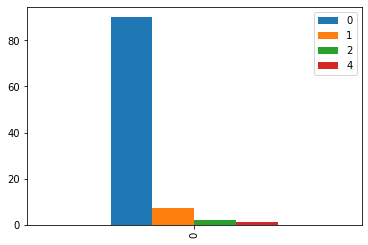

In [ ]:
pd.DataFrame({0:[90], 1:[7], 2:[2], 4:[1]}).plot.bar()

# test 2 : 임계값 0.6

In [ ]:
start_time = time.time()

top_results, df = model.run(df_question.iloc[:100].질문.to_frame(), 'klue/roberta-base', 0.6)

end_time = time.time()

print('추론에 걸린 시간 : ', end_time - start_time)

원래 dataset : 1533

부정적인 질문 list. 총 0개

욕설이 포함된 질문 list. 총 0개

비윤리적 문장인 질문 list. 총 0개

similarity
추론에 걸린 시간 :  88.49914717674255


In [ ]:
print_similar(df_, top_results)

In [ ]:
sum_dict = {}

for query in top_results :
  if len(top_results[query]['idx']) in sum_dict :
    sum_dict[len(top_results[query]['idx'])] += 1
  else :
    sum_dict[len(top_results[query]['idx'])] = 1
sum_dict

{0: 25,
 80: 1,
 35: 2,
 85: 1,
 70: 2,
 8: 1,
 9: 2,
 2: 4,
 5: 3,
 1: 10,
 4: 5,
 27: 1,
 3: 5,
 47: 3,
 16: 4,
 92: 1,
 51: 1,
 10: 1,
 140: 1,
 52: 1,
 54: 1,
 59: 1,
 62: 2,
 6: 1,
 46: 1,
 73: 2,
 72: 1,
 44: 1,
 98: 1,
 7: 1,
 61: 1,
 21: 1,
 55: 1,
 40: 2,
 90: 1,
 57: 1,
 163: 1,
 95: 1,
 75: 1,
 69: 1,
 48: 1,
 30: 1,
 42: 1}

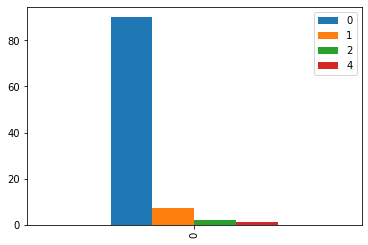

In [ ]:
pd.DataFrame({0:[90], 1:[7], 2:[2], 4:[1]}).plot.bar()